In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
matplotlib.rcParams["figure.figsize"] = [20,10]

In [2]:
#export
from exp.nb_03_cuda_cnn_hooks_init import *

# ConvNet

```
Let's get the data and training interface from where we left in the last notebook.
```

In [3]:
x_train, y_train, x_valid, y_valid = get_data(url=MNIST_URL)

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

nh = 50
bs = 512
c  = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs=bs), c=c)

In [4]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(BatchTransformXCallback, mnist_view)]

nfs = [8,16,32,64,64]

In [8]:
learner, run = get_learn_run(data, nfs, lr=0.4, layer=conv_layer, cbs=cbfs)

In [10]:
%time run.fit(epochs=2, learner=learner)

epoch=[0/2]:	train: [1.071396015625, tensor(0.6595)]	valid: [0.225897509765625, tensor(0.9302)]
epoch=[1/2]:	train: [0.2001832421875, tensor(0.9379)]	valid: [0.15655361328125, tensor(0.9484)]
CPU times: user 33.1 s, sys: 10.5 s, total: 43.7 s
Wall time: 16.6 s


# `BatchNorm`

## Custom BatchNorm
```
Let's start by building our own BatchNorm from scratch.
```

In [5]:
class BatchNorm(torch.nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        ### NOTE: pytorch batchnorm "mom" is opposite of what is generally expected
        self.mom = mom
        self.eps = eps
        self.mults = torch.nn.Parameter(torch.ones(nf, 1, 1))
        self.adds  = torch.nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer("means", torch.zeros(1, nf, 1, 1))
        self.register_buffer("vars", torch.ones(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x-m) / (v + self.eps).sqrt()
        return x*self.mults + self.adds                         ### The final BatchNorm step (x = alpha*x + b)
    

In [6]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    ### No bias is needed while using BatchNorm (due to "self.adds" term in the final BN step)
    layers = [torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=not bn),
              GeneralReLU(**kwargs)]
    if bn:
        layers.append(BatchNorm(nf))
    return torch.nn.Sequential(*layers)

In [7]:
#export

def init_cnn_(module, func):
    if isinstance(module, torch.nn.Conv2d):
        func(module.weight, a=0.1)                      ### "func" is the init function like kaiming_normal, kaiming_uniform etc
        if getattr(module, "bias", None) is not None:
            module.bias.data.zero_()
    for layer in module.children():
        init_cnn_(layer, func)
        
def init_cnn(module, uniform=False):
    func = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(module, func)
            
def get_learn_run(data, nfs, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)    


```
We can now use it to training and see how it helps keep the activations mean~=0 and std~=1
```

In [8]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_layer, cbs=cbfs)

epoch=[0/1]:	train: [0.26624232421875, tensor(0.9157)]	valid: [0.13344666748046874, tensor(0.9603)]


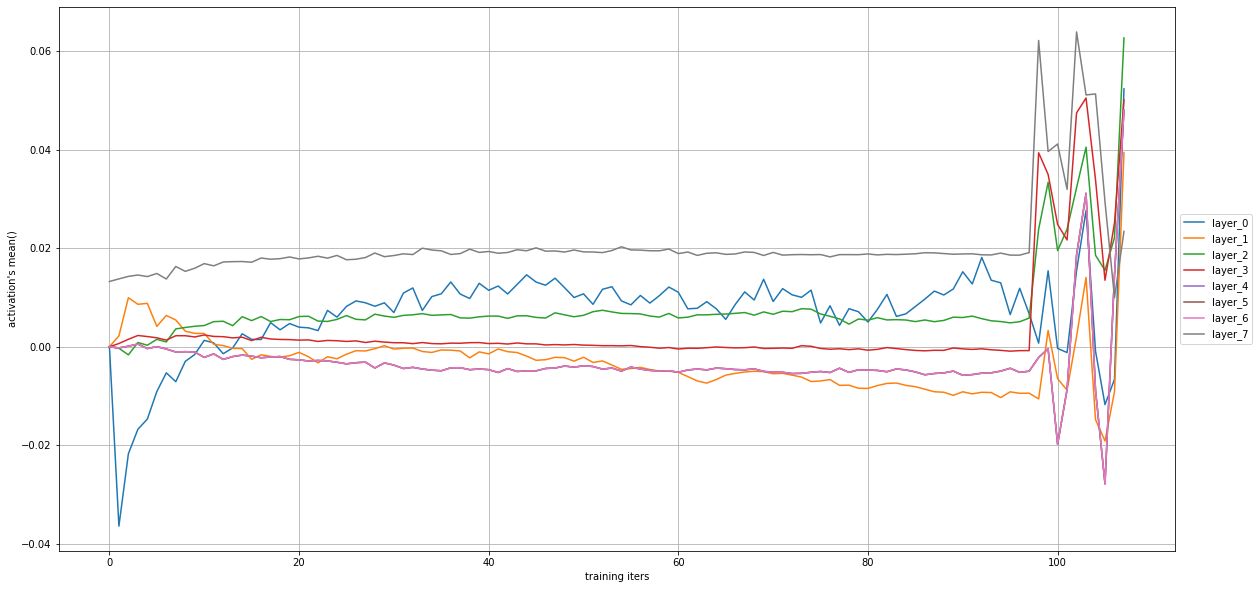

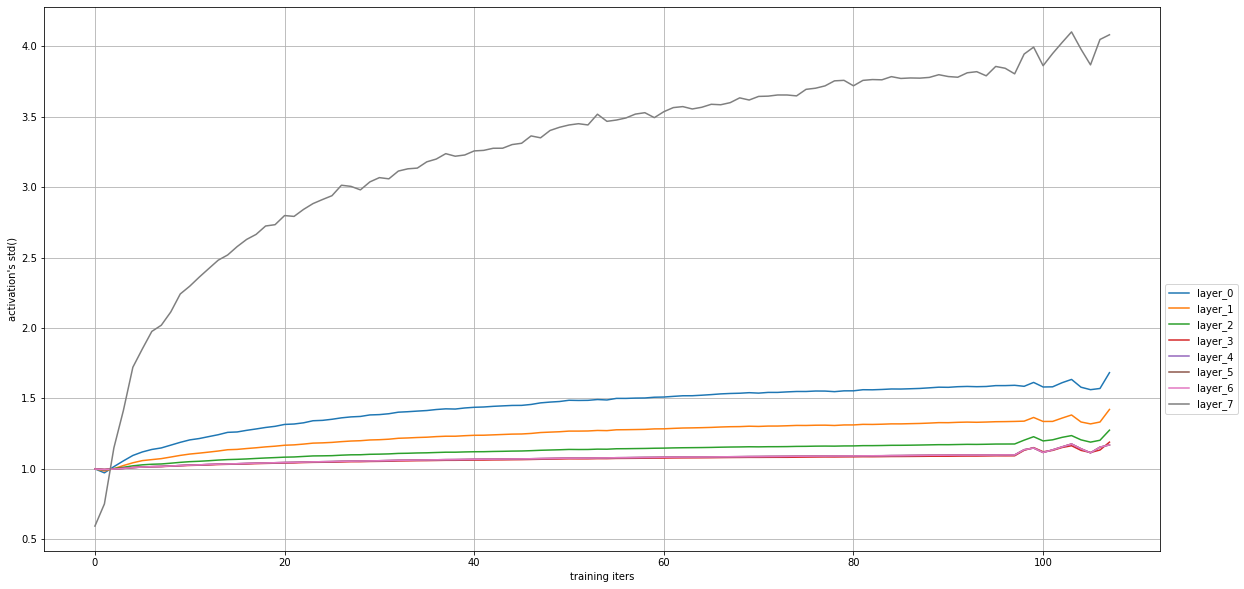

In [31]:
with Hooks(learner.model, append_stats) as hooks:
    run.fit(epochs=1, learner=learner)
    for i, h in enumerate(hooks):
        means, _ = h.stats
        plt.plot(means, label=f"layer_{i}")
        plt.xlabel("training iters")
        plt.ylabel("activation's mean()")
    plt.legend(loc="center left", bbox_to_anchor=(1., 0.5))
    plt.grid()
    
    plt.figure()
    for i, h in enumerate(hooks):
        _, stds = h.stats
        plt.plot(stds, label=f"layer_{i}")
        plt.xlabel("training iters")
        plt.ylabel("activation's std()")
    plt.legend(loc="upper left", bbox_to_anchor=(1., 0.5))
    plt.grid()
    

In [23]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralReLU()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralReLU()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralReLU()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralReLU()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralReLU()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [29]:
list(hooks)

In [35]:
learner, run = get_learn_run(data, nfs, lr=1., layer=conv_layer, cbs=cbfs)

In [36]:
%time run.fit(epochs=3, learner=learner)

epoch=[0/3]:	train: [0.25553294921875, tensor(0.9215)]	valid: [0.16612353515625, tensor(0.9457)]
epoch=[1/3]:	train: [0.082450029296875, tensor(0.9741)]	valid: [0.1712716064453125, tensor(0.9503)]
epoch=[2/3]:	train: [0.0597331689453125, tensor(0.9811)]	valid: [0.09523868408203125, tensor(0.9707)]
CPU times: user 1min 17s, sys: 26.1 s, total: 1min 43s
Wall time: 39.3 s


## Builtin BatchNorm:

In [9]:
#export

def conv_layer(ni, nf, ks, stride=2, bn=True, **kwargs):
    layers = [torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=not bn),
              GeneralReLU(**kwargs)]
    if bn:
        layers.append(torch.nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return torch.nn.Sequential(*layers)


In [10]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_layer, cbs=cbfs)

In [41]:
%time run.fit(epochs=3, learner=learner)

epoch=[0/3]:	train: [0.23233078125, tensor(0.9278)]	valid: [0.09827022094726562, tensor(0.9690)]
epoch=[1/3]:	train: [0.0682938525390625, tensor(0.9781)]	valid: [0.0880052490234375, tensor(0.9722)]
epoch=[2/3]:	train: [0.0447318994140625, tensor(0.9858)]	valid: [0.07009364624023437, tensor(0.9780)]
CPU times: user 1min 23s, sys: 28 s, total: 1min 51s
Wall time: 43.9 s


## With Scheduler:

```
Let's add some warm-up/annealing
```

In [11]:
sched = combine_scheds([0.3, 0.7], [sched_linear(0.6, 2.), sched_linear(2., 0.1)])

In [12]:
learner, run = get_learn_run(data, nfs, lr=0.1, layer=conv_layer,
                             cbs=cbfs + [partial(ParamScheduler, "lr", sched)])

In [45]:
%time run.fit(epochs=7, learner=learner)

epoch=[0/7]:	train: [0.0605444873046875, tensor(0.9815)]	valid: [0.101042919921875, tensor(0.9701)]
epoch=[1/7]:	train: [0.0540584375, tensor(0.9830)]	valid: [0.08844053344726563, tensor(0.9744)]
epoch=[2/7]:	train: [0.0435830322265625, tensor(0.9865)]	valid: [0.0613303955078125, tensor(0.9817)]
epoch=[3/7]:	train: [0.0239383984375, tensor(0.9924)]	valid: [0.05096827392578125, tensor(0.9837)]
epoch=[4/7]:	train: [0.012494891357421874, tensor(0.9967)]	valid: [0.04394786376953125, tensor(0.9875)]
epoch=[5/7]:	train: [0.007947437744140626, tensor(0.9981)]	valid: [0.04125270690917969, tensor(0.9879)]
epoch=[6/7]:	train: [0.004726764526367187, tensor(0.9994)]	valid: [0.040412823486328124, tensor(0.9887)]
CPU times: user 3min 7s, sys: 1min 2s, total: 4min 10s
Wall time: 1min 34s


# More Norms

## Layer Norm:

```
As per the paper, "Batch Normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small". 

So, there is another method of normalization: "Layer Norm".
The idea of "LayerNorm" is very similar to "BatchNorm" except in LayerNorm we normalize across the various hidden dimension instead of batches.

The differences with BatchNorm are:
1. We don't keep a moving average of means and stds.
2. We don;t average over the batches dimension but over the hidden dimension; 
   so it's independent of batch-size.
```

In [13]:
class LayerNorm(torch.nn.Module):
    __constants__ = ["eps"]
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = torch.nn.Parameter(torch.tensor(1.))
        self.add  = torch.nn.Parameter(torch.tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v + self.eps).sqrt())
        return x*self.mult + self.add

In [14]:
def conv_LN(ni, nf, ks=3, stride=2, ln=True, **kwargs):
    layers = [torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=True),
              GeneralReLU(**kwargs)]
    if ln:
        layers.append(LayerNorm())
    return torch.nn.Sequential(*layers)

In [15]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_LN, cbs=cbfs)

In [58]:
%time run.fit(epochs=5, learner=learner)

epoch=[0/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[1/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[2/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[3/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[4/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
CPU times: user 2min 37s, sys: 51 s, total: 3min 28s
Wall time: 1min 27s


#### The above train & valid loss, accuracy shows that the model doesnot learn anything in this dataset...!!! WHY???
```
Thought Experiment:
    1. Can it distinguish between sunny and foggy days?? (assuming you are using it before the 1st conv)!!!
```

## `InstanceNorm` or `ContrastNorm`:
```
The key difference between "InstanceNorm" and "BatchNorm" is that "BatchNorm" applies normalization to whole batch of images instead of single ones.

In order to combine the effects of instance-specific normalization and batch normalization, the paper authors proposed to replace the BatchNorm with "InstanceNorm" (aka "ContrastNorm") layer.
```

In [16]:
class InstanceNorm(torch.nn.Module):
    __constants__ = ["eps"]
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = torch.nn.Parameter(torch.ones(nf, 1, 1))
        self.adds  = torch.nn.Parameter(torch.zeros(nf, 1, 1))
    
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var((2,3), keepdim=True)
        x = (x-m) / ((v + self.eps).sqrt())
        return x*self.mults + self.adds

In [17]:
def conv_IN(ni, nf, ks, stride=2, IN=True, **kwargs):
    layers = [torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=True),
              GeneralReLU(**kwargs)]
    if IN:
        layers.append(InstanceNorm(nf))
    return torch.nn.Sequential(*layers)

In [18]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_IN, cbs=cbfs)

In [19]:
%time run.fit(epochs=5, learner=learner)

epoch=[0/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[1/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[2/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[3/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
epoch=[4/5]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
CPU times: user 3min 9s, sys: 51.8 s, total: 4min 1s
Wall time: 1min 29s


```
If we look at the train and valid results from above run; we see that the losses are NaN and accuracy~=0...
Why is that so???
Why is the network not learning anything after "InstanceNorm"???
```

## `GroupNorm`
```
"GroupNorm" takes the advantage of both "BatchNorm" and "LayerNorm".
1. It creates random groups across the contiguous batches & channel dimension and use normalization within those.
```

### GroupNorm: From PyTorch Docs-->

```python
GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)
```

#### Features of GroupNorm:
1. The input channels are separated into "num_groups" groups.
2. Each "group" contains "num_channels / num_groups" channels.
3. The mean and standard-deviatin are calculated separately over each "group".
4. if affine=True:
    * "self.mults"(i.e. gamma) and "self.adds"(i.e. beta) are learnable per-channel affine transform param vectors of size "num_channels".
    
5. This "GroupNorm" layer uses statistics  computed from input data in both training and evaluation modes.

#### Args:
* `num_groups`   (`int`): number of groups to separate the channels into.
* `num_channels` (`int`): number of channels expected in input
* `eps`                 : a value added to denominator for numerical stability.
* `affine`      (`bool`): a boolean value that ehen set to True, this module has learnable per-channels affine 
                          transform parameters initialized to ones(weights) & zeros(bias). Default: True
               
#### Shape:
* Input : (N, num_channels, *) 
* Output: (N, num_channels, *)   ==> same as input size
    
#### Examples:

```python
input = torch.randn(20, 6, 10, 10)

m = torch.nn.GroupNorm(num_groups=3, num_channels=6)           ### <-- separate 6 channels into 3 groups

m = torch.nn.GroupNorm(num_groups=6, num_channels=6)           ### <-- (equivalent to InstanceNorm)
                                                               ###     separate 6 channels into 6 groups
    
m = torch.nn.GroupNorm(num_groups=1, num_channels=6)           ### <-- (equivalent to LayerNorm)
                                                               ###     separate 6 channels into 1 group
```

# Fix small batch sizes

## What's the problem?

```
When we compute the statistics (mean & std) ofa  BatchNorm layer on a small batch, it is possible that we get a standard deviation very close to ZERO; because there aren't many samples (std of a single sample is 0 b'coz sample's value is equal to its mean)

```

In [23]:
### get a data buch with small batch size (bs=2)
data = DataBunch(*get_dls(train_ds, valid_ds, bs=2), c=c)

In [24]:
def conv_layer(ni, nf, ks, stride=2, bn=True, **kwargs):
    layers = [torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=not bn),
              GeneralReLU(**kwargs)]
    if bn:
        layers.append(torch.nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return torch.nn.Sequential(*layers)
        

In [25]:
learner, run = get_learn_run(data, nfs, lr=0.9, layer=conv_layer, cbs=cbfs)

In [26]:
%time run.fit(epochs=1, learner=learner)

epoch=[0/1]:	train: [533.327, tensor(0.1171)]	valid: [19.896234375, tensor(0.1417)]
CPU times: user 10min 29s, sys: 5min 43s, total: 16min 12s
Wall time: 5min 53s


```
If we look at the above results, we can see that with bs=2, the model performed terriblely bad (accuracy~=11% only) even with BatchNorm layer.

This is the problem we face with "lower batch size" data with BatchNorm layer.... :(

What can we do to resolve this....?!!!
```

## `Running Batch Norm`:

```
To solve the problem of lower-batch-size we introduce a "Running BatchNorm" layer that uses "smoother running" mean & variance for the mean and std.
```

In [35]:
class RunningBatchNorm(torch.nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = torch.nn.Parameter(torch.ones(nf, 1, 1))
        self.adds  = torch.nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer("sums", torch.zeros(1, nf, 1, 1))
        self.register_buffer("sqrs", torch.zeros(1, nf, 1, 1))
        self.register_buffer("batch", torch.tensor(0.))
        self.register_buffer("count", torch.tensor(0.))
        self.register_buffer("step", torch.tensor(0.))
        self.register_buffer("dbias", torch.tensor(0.))
        
    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        
        s  = x.sum(dims, keepdim=True)                      ### the sums
        ss = (x*x).sum(dims, keepdim=True)                  ### the sum-of-squares
        c  = self.count.new_tensor(x.numel()/nc)            ### #data count per channel
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training:
            self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums /= self.dbias
            sqrs /= self.dbias
            c    /= self.dbias
        
        means = sums/c
        vars  = (sqrs/c).sub_(means*means)
        
        if bool(self.batch < 20):                         ### handeling for lower batch size inputs
            vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [36]:
def conv_RBN(ni, nf, ks=3, stride=2, rbn=True, **kwargs):
    layers = [torch.nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=not rbn),
              GeneralReLU(**kwargs)]
    if rbn:
        layers.append(RunningBatchNorm(nf))
    return torch.nn.Sequential(*layers)

In [40]:
learner, run = get_learn_run(data, nfs, lr=0.4, layer=conv_RBN, cbs=cbfs)

In [41]:
%time run.fit(epochs=1, learner=learner)

epoch=[0/1]:	train: [nan, tensor(0.0986)]	valid: [nan, tensor(0.0991)]
CPU times: user 11min 22s, sys: 6min 28s, total: 17min 51s
Wall time: 6min 30s


# Export

In [42]:
!python notebook_to_script.py imflash217__03_batchnorm.ipynb

Converted imflash217__03_batchnorm.ipynb to exp/nb_03_batchnorm.py
Converted imflash217__03_batchnorm.ipynb to exp/nb_03_batchnorm.py
Converted imflash217__03_batchnorm.ipynb to exp/nb_03_batchnorm.py
